In [1]:
%pylab inline
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms

In [3]:
base_path = '100_leaves_plant_species/data'

In [4]:
transform = transforms.Compose([
                                transforms.Grayscale(),
                                transforms.Resize((60, 60)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])
                               ])

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
imgset = torchvision.datasets.ImageFolder(base_path, transform=transform)

In [7]:
trainset = torch.utils.data.Subset(imgset, range(1200))
testset = torch.utils.data.Subset(imgset, range(1200, 1600))

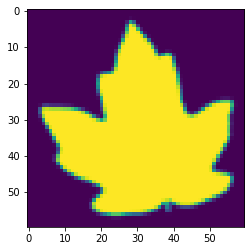

In [8]:
for i, (im, l) in enumerate(trainset):
    if i == 14:
        imshow(im.view(60, 60))
        break

In [9]:
class LeafNet(nn.Module):

    def __init__(self):
        super(LeafNet, self).__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(1, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 96, 3),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.lins = nn.Sequential(
            nn.Linear(16224, 8112),
            nn.ReLU(inplace=True),
            nn.Linear(8112, 4056),
            nn.ReLU(inplace=True),
        )
        
        self.classifier = nn.Linear(4056, 100)
        self.dropout = nn.Dropout(0.15)

    def forward(self, x):
        x = self.convs(x)
        x = self.dropout(x)

        # print('shape', x.shape)
        x = x.reshape(x.size(0), -1)
        x = self.lins(x)

        x = self.classifier(x)

        return x


model = LeafNet()
model.to('cuda:0')

LeafNet(
  (convs): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lins): Sequential(
    (0): Linear(in_features=16224, out_features=8112, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=8112, out_features=4056, bias=True)
    (3): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=4056, out_features=100, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
)

In [10]:
optimizer = optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999), eps=1e-7, amsgrad=False) # 3e-4 0.0003

EPOCHS = 10
BATCH = 12

loss_fn = nn.CrossEntropyLoss()

In [11]:
trainloader = torch.utils.data.DataLoader(imgset, batch_size=BATCH, num_workers=12, shuffle=True)

In [ ]:
accuracies = []
losses = []

model.train();
for epoch in trange(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        images, labels = data[0].to('cuda:0'), data[1].to('cuda:0')
        optimizer.zero_grad()
        
        out = model(images)
        
        loss = loss_fn(out, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(out, 1)

        accuracy = (predicted == labels).float().mean()

        accuracies.append(accuracy.item())
        losses.append(loss.item())
    
    print('Epoch', epoch, 'loss', running_loss / len(trainloader))

 10%|██████▍                                                         | 1/10 [00:07<01:11,  7.95s/it]

Epoch 0 loss 4.159178217845176


 20%|████████████▊                                                   | 2/10 [00:14<00:59,  7.42s/it]

Epoch 1 loss 2.215607251693953


 30%|███████████████████▏                                            | 3/10 [00:22<00:50,  7.26s/it]

Epoch 2 loss 1.5034945037827563


 40%|█████████████████████████▌                                      | 4/10 [00:29<00:43,  7.19s/it]

Epoch 3 loss 1.0971002235675036


 50%|████████████████████████████████                                | 5/10 [00:36<00:35,  7.15s/it]

Epoch 4 loss 0.8411254491935025


 60%|██████████████████████████████████████▍                         | 6/10 [00:43<00:28,  7.13s/it]

Epoch 5 loss 0.6810247963711397


 70%|████████████████████████████████████████████▊                   | 7/10 [00:50<00:21,  7.11s/it]

Epoch 6 loss 0.5516314556015961


 80%|███████████████████████████████████████████████████▏            | 8/10 [00:57<00:14,  7.10s/it]

Epoch 7 loss 0.43304018537277605


 90%|█████████████████████████████████████████████████████████▌      | 9/10 [01:04<00:07,  7.11s/it]

Epoch 8 loss 0.3273882108059392


In [ ]:
plt.plot(range(len(accuracies)), accuracies, 'g', label='Accuracy')
plt.plot(range(len(losses)), losses, 'b', label='Loss')
plt.title('Accuracy and Loss')
plt.show()

In [ ]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, num_workers=12, shuffle=True)

In [ ]:
total = 0
correct = 0

with torch.no_grad():
    model.eval();
    for data in tqdm(testloader):
        images, labels = data[0].to('cuda:0'), data[1].to('cuda:0')
        out = model(images)
        _, predicted = torch.max(out, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('total', total)
print('correct', correct)
print('accuracy', round(correct / total, 3))